# **Part 2: Conditional DDPM for Image Super Resolution** (20 points)

**Main objective**: Learn a generative model to generate high-resolution images (32×32 pixels) conditioned on low-resolution images (16×16 pixels) (an Image-to-Image problem).

### **Learning Objectives**
- Implement and train a conditional DDPM for Image Super Resolution on the `CelebA` dataset
- Quantitatively evaluate model performance using `Mean Squared Error (MSE)` and `Learned Perceptual Image Patch Similarity (LPIPS)` metrics

### **Implementation Tasks**

1. **Dataset Preparation**
2. **Conditional DDPM**:
   - Initialize a conditional neural network architecture
   - Precompute diffusion coefficients
   - Implement forward and backward diffusion process sampling
   - Train a conditional DDPM that generates high-resolution images given low-resolution images

3. **Evaluation**:
   - Compute MSE and LPIPS metrics:
     - Between low-resolution and ground truth high-resolution images
     - Between generated high-resolution and ground truth high-resolution images

### **Resources**
- **DDPM original paper:** [link](https://arxiv.org/abs/2006.11239)
- **M2L School DDPM tutorial:** [link](https://github.com/M2Lschool/tutorials2024/tree/main/3_diffusion)

In [ ]:
# Load necessary libraries

import torch
import torch.utils
import torch.utils.data
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder, MNIST
from IPython.display import clear_output
from tqdm import tqdm

from typing import Generator, Tuple, Dict, Optional, Union

device = "cuda" if torch.cuda.is_available() else "cpu"
import warnings

warnings.filterwarnings("ignore")

## Part 1. Dataset Preparation (3 points)

The Image Super Resolution task involves transforming low-resolution images to high-resolution images. The dataset will consist of paired low-resolution and high-resolution CelebA images.

### Part 1.1. Load the CelebA dataset (32×32 pixels) (3 points)

**Note**: Unfortunately, it is nearly impossible to download the CelebA dataset using basic PyTorch. Therefore, you are allowed to load the dataset in whatever way works best for you. However, the course team suggests:
- Loading all CelebA files manually from Google Drive links.
- Placing them either in your local file system or unpacking them in Google Colab.

In [ ]:
n_channels = 3
image_size = 32

celeba_transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize((image_size, image_size)),
                torchvision.transforms.Normalize([0.5],[0.5])
            ])

train_dataset = <your code here>
val_dataset = <your code here>


Let us visualize some samples

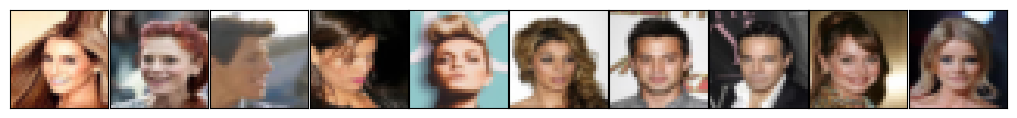

In [ ]:
def plot_images(batch_x, title=None):
    batch_x = batch_x.clamp(-1, 1)
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    if title is not None:
        fig.suptitle(title)
    for i in range(10):
        axes[i].imshow(
            batch_x[i].squeeze().permute([1, 2, 0]) * 0.5 + 0.5, cmap="gray"
        )  # <you may need to change this line>
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)
    plt.show()


plot_images(torch.stack([train_dataset[i][0] for i in range(10)], dim=0))

### Part 1.2. Produce Low-Resolution CelebA Images (16×16)

To produce low-resolution images, we will take the high-resolution images and apply bicubic downscaling.

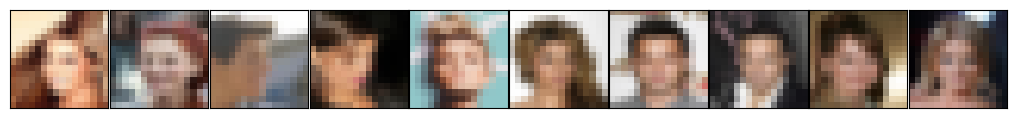

In [ ]:
from torchvision.transforms.functional import resize as resize_fn

x = torch.stack([train_dataset[i][0] for i in range(10)])

low_res_images = resize_fn(x, (image_size // 2, image_size // 2))

plot_images(low_res_images)

Then, we will upscale the low-resolution image to 32×32 pixel resolution using a baseline super-resolution method (i.e., bicubic upscaling). This will serve as the condition for our generative model.

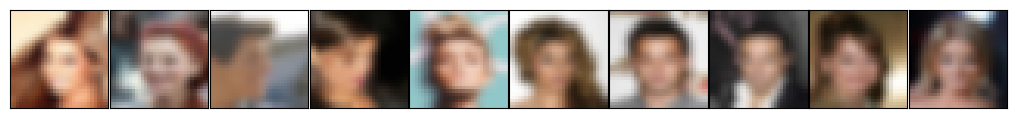

In [ ]:
corrupt_fn = lambda x: resize_fn(resize_fn(x, (image_size // 2, image_size // 2)), (image_size, image_size))

y = corrupt_fn(x)

plot_images(y)

## Part 2. Conditional DDPM (13 points)

In this section, you will:

- Implement conditioning for the DDPM
- Precompute the DDPM coefficients
- Implement sampling from forward and backward diffusion processes

The notation in this notebook is compatible with the [original DDPM paper](https://arxiv.org/abs/2006.11239), so you may reference it for additional information.

### Part 2.1. Conditional DDPM Architecture (2 points)

In DDPM, we predict noise using a neural network $\epsilon_\theta(x_t, t)$ that takes as input a diffusion sample $x_t$ and time moment $t$, and outputs a noise prediction, i.e., $\epsilon_\theta(x_t, t): \mathbb{R}^D \times \mathbb{R} \rightarrow \mathbb{R}^D$.

However, in the case of conditional DDPM, we must add a conditioning input - an image $y \in \mathbb{R}^D$, resulting in $\epsilon_\theta(x_t, y, t): \mathbb{R}^D \times \mathbb{R}^D \times \mathbb{R} \rightarrow \mathbb{R}^D$.

For the neural network architecture, a [U-Net](https://arxiv.org/abs/1505.04597) is commonly used. To incorporate the conditioning, one can simply concatenate the two images along the channels dimension and use a regular U-Net architecture.

In [64]:

class ConditionalNoisePredictor(nn.Module):
    def __init__(self, image_size=32):
        super().__init__()        
        # hint: one could use U-net neural network from diffusers
        self.net = <your code here>

    def forward(self, x_t, condition, t):
        
        ret_val = <your code here>
            
        return ret_val
        


### Part 2.2.1. Diffusion Coefficients (4 points)

Following the notation from the [original DDPM paper](https://arxiv.org/abs/2006.11239), we will precompute the helper diffusion coefficients $\beta_t$, $\alpha_t$, $\bar{\alpha}_t$, and $\bar{\alpha}_{t-1}$, which depend on $T$, $\beta_{\text{min}}$, and $\beta_{\text{max}}$:

$\beta_t = \frac{t}{T} \cdot \beta_{\text{min}} + \left(1 - \frac{t}{T}\right) \cdot \beta_{\text{max}}$

$\alpha_t = 1 - \beta_t$

$\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$

The `get_coeffs` function should take as input he number of diffusion steps $T$, $\beta_{\text{min}}$, $\beta_{\text{max}}$nand output a dictionary containing all the helper diffusion coefficients.

**Note**: $\bar{\alpha}_{t-1}$ is simply a shifted version of the $\bar{\alpha}_{t}$ array, included for convenience.

In [16]:


def get_coeffs(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
    ):
    
    # define \beta_t coefficients
    betas = <your code here>
    
    # define \alpha_t coefficients
    alphas = <your code here>
    
    # define \bar{\alpha_t} coefficients
    alphas_hat = <your code here>

    # define special shifted array of \bar{\alpha_{t-1}} coefficients
    alphas_hat_prev = <your code here>
        
    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_hat": alphas_hat,
        "alphas_hat_prev": alphas_hat_prev,
    }

    

### Part 2.2.2. Diffusion Class with Forward and Backward Diffusion Sampling (4 points)

Now you will implement methods of the `CondDiffusion` class using the provided diffusion coefficients ($\beta_t, \alpha_t, \bar{\alpha}_t, \bar{\alpha}_{t-1}$).

- `forward_sample` method implements sampling from forward diffusion $q(x_t|x_0)$:
  - The `return_noise` flag indicates whether to return the normal noise sample used for sampling $x_t$ (required for the learning procedure)
  - Forward diffusion: $x_t \sim q(x_t|x_0) = \mathcal{N}(x_t|\sqrt{\bar{\alpha}_t}x_0, (1 - \bar{\alpha}_t)\mathbb{I})$

- `backward_sample` method implements sampling from backward diffusion $p_{\theta}(x_{t-1}|x_t)$:
  - The Markov chain should start from $x_T \sim \mathcal{N}(0, \mathbb{I})$
  - Backward diffusion: $x_{t-1} \sim p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}|\mu_{\theta}(x_t, t), \sigma^2_t \mathbb{I})$
    - $\mu_{\theta}(x_t, t) = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta(x_t, t))$, where $\epsilon_\theta(x_t, t)$ is the learned noise predictor
    - $\sigma^2_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}\beta_t$
  - $x_0$ will be the final generative model sample
  - The `return_traj` flag indicates whether to return all samples from the backward diffusion trajectory (useful for visualization)

In [ ]:
class CondDiffusion:
  def __init__(self, noise_predictor_model: ConditionalNoisePredictor, coeffs_dict, T=1000):

    self.model = noise_predictor_model

    self.T = T

    self.alphas = coeffs_dict['alphas'].to(device)
    self.betas = coeffs_dict['betas'].to(device)
    self.alphas_hat = coeffs_dict['alphas_hat'].to(device)
    self.alphas_hat_prev = coeffs_dict['alphas_hat_prev'].to(device)

  def forward_sample(self, x_0, t, return_noise=True):
    '''
        Forward diffusion process sampling q(x_t|x_0) = \mu(x_0) + \sigma(t) * noise
        If return_noise=True return noise samples used to generate x_t
    '''

    noise = torch.randn_like(x_0).to(device)

    x_t = <your code>
        
    if return_noise:

      return x_t, noise
    
    return x_t

  @torch.no_grad()
  def backward_sample(self, condition_x, return_traj=False):
    '''
        Sample from backward diffusion p_{\theta}(x_{t-1}|x_t)
    '''
    
    x_t = torch.randn([condition_x.shape[0], n_channels, image_size, image_size]).to(device)
    
    if return_traj:
        traj = [x_t]
    
    for t in tqdm(reversed(range(self.T))):
        
        x_t = <your code here>
        
        if return_traj:
            traj.append(x_t)
    
    if return_traj:
        return x_t, traj
    return x_t


### Part 2.3. Loss function, neural network intialization and training (3 points)

Instead of trying to generate the high resolution image directly, it is easier to generate the delta between high resolution images and low resolution images, i.e., $\Delta = HighRes - LowRes$.

At the inference stage one should just sum generated $\hat{\Delta}$ with $LowRes$


In [ ]:
def loss_fn(diffusion: CondDiffusion, x, condition, t):

  loss = <your code here>

  return loss


In [ ]:
T = 1000

beta_min = 1e-4

beta_max = 0.02

lr = 1e-4

batch_size = 64

n_epochs = 3

In [ ]:
noise_predictor_model = ConditionalNoisePredictor(image_size=image_size).to(device)

coeffs_dict = get_coeffs(T=T, beta_min=beta_min, beta_max=beta_max)

diffusion = CondDiffusion(noise_predictor_model, coeffs_dict, T=T)

opt = torch.optim.Adam(noise_predictor_model.parameters(), lr=lr)

In [ ]:
def train(diffusion, opt, train_loader, corrupt_fn, batch_size=64, n_epochs=10):
  diffusion.model.train()

  for n in range(n_epochs):
      
      pbar = tqdm(enumerate(iter(train_loader)))
    
      for i, batch in pbar:
    
        x = batch[0].to(device)

        y = corrupt_fn(x)

        # Randonly generate a batch of timesteps (from 0 to T)
        t = <your code>
        
        delta_x = x - y
        
        loss = loss_fn(diffusion, delta_x, y, t)
    
        opt.zero_grad()
    
        loss.backward()
    
        opt.step()
        
        pbar.set_description(f'Loss: {loss}')
        


In [ ]:
model.train()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train(diffusion, opt, train_loader, corrupt_fn, n_epochs=n_epochs)

Loss: 0.03624144196510315: : 2544it [07:18,  5.80it/s]  
Loss: 0.028886189684271812: : 2544it [06:41,  6.34it/s] 
Loss: 0.006938147358596325: : 2544it [06:21,  6.67it/s] 


**Hints**: 

- DDPM may experience *color shift* and you may see yellow or green images, it is ok just keep on training
- The sharpness of face lines can be considered as a good sign of DDPM training procedure success
  

## Part 3: Evaluation (4 points)

Here you are asked to visualize result of conditional DDPM generation, diffusion trajectory and calculate MSE/LPIPS metrics.



In [ ]:
model.eval()

### Part 3.1: Visualization (0 points)

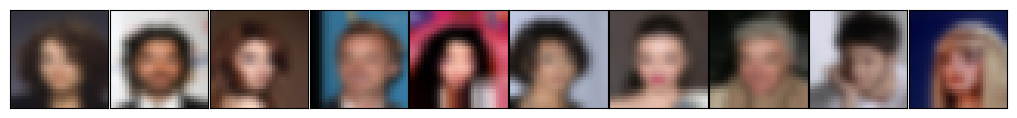

In [ ]:
low_res = corrupt_fn(next(iter(val_loader))[0][:12]).to(device)

plot_images(low_res.cpu())

1000it [00:17, 56.07it/s]


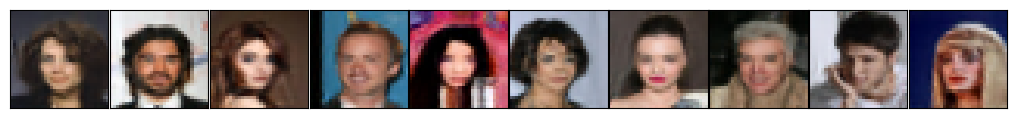

In [91]:

delta_x = <your code here>

high_res_generations = delta_x + low_res

plot_images(high_res_generations.cpu())


### Part 3.2: Backward diffusion trajectory (1 point)

Show 10 backward diffusion samples from a single trajectory (remember `return_traj=True` flag). Show the trajectories for 

- Generated delta

- Generated delta + LowRes


1000it [00:17, 55.67it/s]


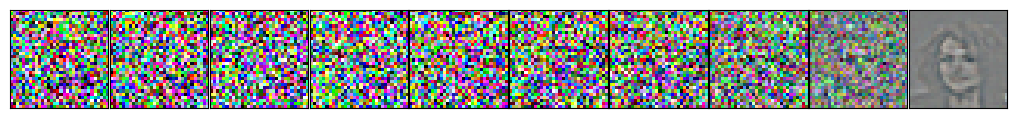

In [92]:

low_res = corrupt_fn(next(iter(val_loader))[0][:12]).to(device)

# plot CondDDPM generation trajectory

plot_images(<your code here>)


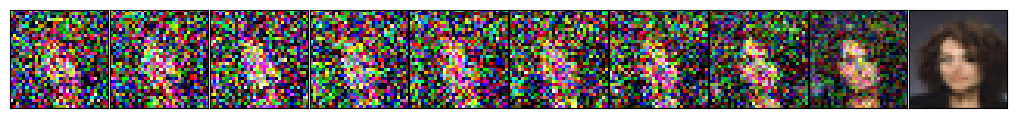

In [93]:

# plot CondDDPM generation trajectory + low_res

plot_images(<your code here>)


### Part 3.3: Metrics (3 points)

To quantitatively evaluate generation quality, we will calculate paired metrics: MSE and [LPIPS](https://github.com/richzhang/PerceptualSimilarity).

- **MSE(x, y)**: Computes the mean squared error (lower values indicate better quality)
- **LPIPS(x, y)**: Computes MSE in the latent space of a neural network with learned perceptual features, which helps:
  - Incorporate image semantics.
  - Better correlate with human perception.


Compute metrics on mini-batch between low resolution image and ground truth high resolution image.

In [96]:

import lpips

high_res = next(iter(val_loader))[0][:10].to(device)

low_res = corrupt_fn(high_res)

# Compute LPIPS distance metric between ground truth high resolution image and low resolution image. LPIPS(high_res, low_res)
d_lpips_bicubic = <your code here>

# Compute MSE between ground truth high resolution image and low resolution image. MSE(high_res, low_res)
d_mse_bicubic = <your code here>

print(f'Baseline LPIPS: {d_lpips_bicubic} MSE: {d_mse_bicubic}')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /trinity/home/sergei.kholkin/.conda/envs/mdlm/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Baseline LPIPS: 1.3511466979980469 MSE: 0.01991446129977703


Compute metrics on mini-batch between low resolution image and ground truth high resolution image

In [97]:

ddpm_high_res = diffusion.backward_sample(low_res) + low_res

# Compute LPIPS distance metric between high resolution image and CondDDPM model generated high resolution. LPIPS(high_res, ddpm_high_res)
d_lpips_ddpm = <your code here>

# Compute MSE between ground truth high resolution image and low resolution upscaled by bicubic method. LPIPS(high_res, low_res)
d_mse_ddpm = <your code here>

print(f'DDPM LPIPS: {d_lpips_ddpm} MSE: {d_mse_ddpm}')


1000it [00:18, 55.47it/s]

DDPM LPIPS: 0.03920812904834747 MSE: 0.005482598207890987


#### Now calculate metrics on the validation dataset (or medium sized subset)

In [ ]:

# Validation part of CelebA is pretty big so you can take a medium sized subset, e.g., 3000 samples
indices = np.arange(len(val_dataset))[:3000]
val_dataset = torch.utils.data.Subset(val_dataset, indices)

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, drop_last=False)

lpips_ddpm = 0

lpips_baseline = 0.

mse_ddpm = 0.

mse_baseline = 0.

for item in iter(val_loader):

    lpips_ddpm = <your code is here>
    lpips_baseline = <your code is here>
    mse_ddpm = <your code is here>
    mse_baseline = <your code is here>

print(f'Baseline MSE: {mse_baseline} vs DDPM MSE: {mse_ddpm}')
print(f'Baseline LPIPS: {lpips_baseline} vs DDPM LPIPS: {lpips_ddpm}')


1000it [00:20, 48.53it/s]
1000it [00:20, 48.56it/s]
1000it [00:20, 48.80it/s]
1000it [00:20, 48.55it/s]
1000it [00:20, 48.70it/s]
1000it [00:20, 48.97it/s]
1000it [00:20, 48.54it/s]
1000it [00:20, 48.81it/s]
1000it [00:20, 48.73it/s]
1000it [00:20, 48.71it/s]
1000it [00:20, 48.90it/s]
1000it [00:20, 48.64it/s]
1000it [00:20, 48.58it/s]
1000it [00:20, 48.66it/s]
1000it [00:20, 48.67it/s]
1000it [00:20, 48.60it/s]
1000it [00:20, 48.78it/s]
1000it [00:20, 49.02it/s]
1000it [00:20, 48.76it/s]
1000it [00:20, 48.79it/s]
1000it [00:20, 48.95it/s]
655it [00:13, 48.92it/s]